In [34]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product
import h5py

import gym
import numpy as np
import matplotlib
import matplotlib.cm
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv
from stable_baselines3.common.vec_env import VecTransposeImage

sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

from interp.common.wrappers import CustomRewardWrapper, BlurBreakoutScore, BlurSeaquestScore

In [35]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


In [36]:
env_id = "BreakoutNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 3
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [37]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, 
                      n_envs=n_envs,
                      stats_path=stats_path, 
                      seed=seed, 
                      log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

# model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [6]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/breakout_rm_v1.pt"))

<All keys matched successfully>

# Compare blurred vs. non-blurred rewards

In [22]:
blurred = CustomRewardWrapper(BlurBreakoutScore(env), rm)
blurred_obs = blurred.reset()
non_blurred = CustomRewardWrapper(env, rm)
non_blurred_obs = non_blurred.reset()

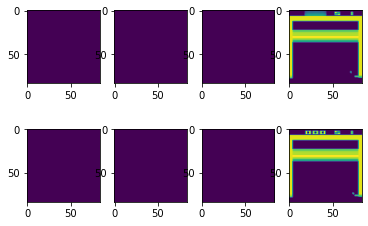

In [23]:
for k in range(4):
    plt.subplot(2, 4, k+1)
    plt.imshow(blurred_obs[0, :, :, k])
for k in range(4):
    plt.subplot(2, 4, 4+k+1)
    plt.imshow(non_blurred_obs[0, :, :, k])

In [25]:
for _ in range(10):
    obs, reward, done, info = non_blurred.step([0])
    print(f"Baseline: {reward.item()}")
    obs, reward, done, info = blurred.step([0])
    print(f"Blured:   {reward.item()}")

Baseline: 0.00442592054605484
Blured:   -0.0008994713425636292
Baseline: 0.008044153451919556
Blured:   0.0036692731082439423
Baseline: 0.009029045701026917
Blured:   0.0078512504696846
Baseline: 0.0019236057996749878
Blured:   0.002749081701040268
Baseline: -0.0014254599809646606
Blured:   -0.018477119505405426
Baseline: 0.009193278849124908
Blured:   0.011905387043952942
Baseline: -0.0007374584674835205
Blured:   -0.0012349411845207214
Baseline: 0.003374435007572174
Blured:   0.005270332098007202
Baseline: -0.00029508769512176514
Blured:   0.00023503601551055908
Baseline: -0.010874062776565552
Blured:   0.3269747495651245


# meh seems like blurring doesn't change the rewards too much on breakout. let's see about seaquest

In [26]:
env_id = "SeaquestNoFrameskip-v4"
folder = "../agents"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [27]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, 
                      n_envs=n_envs,
                      stats_path=stats_path, 
                      seed=seed, 
                      log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

# model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [29]:
rm = RewardModel(env, device)
rm.load_state_dict(th.load("../reward-models/seaquest_rm_v1.pt"))

<All keys matched successfully>

In [30]:
blurred = CustomRewardWrapper(BlurSeaquestScore(env), rm)
blurred_obs = blurred.reset()
non_blurred = CustomRewardWrapper(env, rm)
non_blurred_obs = non_blurred.reset()

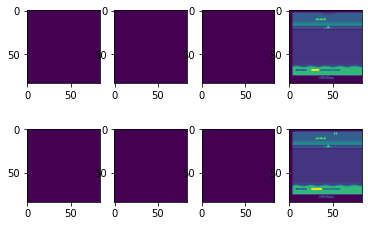

In [31]:
for k in range(4):
    plt.subplot(2, 4, k+1)
    plt.imshow(blurred_obs[0, :, :, k])
for k in range(4):
    plt.subplot(2, 4, 4+k+1)
    plt.imshow(non_blurred_obs[0, :, :, k])

In [32]:
for _ in range(10):
    obs, reward, done, info = non_blurred.step([0])
    print(f"Baseline: {reward.item()}")
    obs, reward, done, info = blurred.step([0])
    print(f"Blured:   {reward.item()}")

Baseline: 0.02186793088912964
Blured:   0.01074950397014618
Baseline: 0.021976187825202942
Blured:   -0.0041172802448272705
Baseline: 0.02351723611354828
Blured:   -0.01067216694355011
Baseline: 0.024495944380760193
Blured:   -0.004491761326789856
Baseline: 0.026918485760688782
Blured:   -0.0036377757787704468
Baseline: 0.028194919228553772
Blured:   -0.002283245325088501
Baseline: 0.0292675644159317
Blured:   -0.0004720240831375122
Baseline: 0.03135572373867035
Blured:   -0.0004504173994064331
Baseline: 0.028633669018745422
Blured:   0.0006993860006332397
Baseline: 0.028686881065368652
Blured:   -0.0018397718667984009


# So it also seems similar here, however it hasn't scored yet... so I bet it would be quite different if it scored